#**MNIST dataset and scikit-learn with Azure Machine Learning**

## Set up your development environment

All the setup for your development work can be accomplished in a Python notebook.  Setup includes:

* Importing Python packages
* Connecting to a workspace to enable communication between your local computer and remote resources
* Creating an experiment to track all your runs
* Creating a remote compute target to use for training

### Import packages

Import Python packages you need in this session. Also display the Azure Machine Learning SDK version.

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import azureml.core
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.18.0


### Connect to workspace

Create a workspace object from the existing workspace. `Workspace.from_config()` reads the file **config.json** and loads the details into an object named `ws`.

In [ ]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, sep='\t')

try23	eastasia	aidemos


### Create experiment

Create an experiment to track the runs in your workspace. A workspace can have muliple experiments. 

In [ ]:
experiment_name = 'sklearn-mnist'

from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

Create or Attach existing compute resource


**Creation of compute takes approximately 5 minutes.** If the AmlCompute with that name is already in your workspace the code will skip the creation process.

In [ ]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# choose a name for your cluster
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "cpu-cluster")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)

# This example uses CPU VM. For using GPU VM, set SKU to STANDARD_NC6
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D2_V2")


if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print("found compute target: " + compute_name)
else:
    print("creating new compute target...")
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size,
                                                                min_nodes = compute_min_nodes, 
                                                                max_nodes = compute_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)
    
    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
    
     # For a more detailed view of current AmlCompute status, use get_status()
    print(compute_target.get_status().serialize())

creating new compute target...
Creating
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned
{'currentNodeCount': 0, 'targetNodeCount': 0, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2020-12-07T12:35:50+00:00', 'errors': None, 'creationTime': '2020-12-07T12:35:46.130072+00:00', 'modifiedTime': '2020-12-07T12:36:01.857892+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 4, 'nodeIdleTimeBeforeScaleDown': 'PT120S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_D2_V2'}


You now have the necessary packages and compute resources to train a model in the cloud. 

## Explore data

Before you train a model, you need to understand the data that you are using to train it. In this section you learn how to:

* Download the MNIST dataset
* Display some sample images

**Download the MNIST dataset**

Use Azure Open Datasets to get the raw MNIST data files. [Azure Open Datasets](https://docs.microsoft.com/azure/open-datasets/overview-what-are-open-datasets) 




In [ ]:
from azureml.core import Dataset
from azureml.opendatasets import MNIST

data_folder = os.path.join(os.getcwd(), 'data')
os.makedirs(data_folder, exist_ok=True)

mnist_file_dataset = MNIST.get_file_dataset()
mnist_file_dataset.download(data_folder, overwrite=True)

mnist_file_dataset = mnist_file_dataset.register(workspace=ws,
                                                 name='mnist_opendataset',
                                                 description='training and test dataset',
                                                 create_new_version=True)

### Display some sample images

Load the compressed files into `numpy` arrays. Then use `matplotlib` to plot 30 random images from the dataset with their labels above them. Note this step requires a `load_data` function that's included in an `utils.py` file. This file is included in the sample folder. Please make sure it is placed in the same folder as this notebook. The `load_data` function simply parses the compresse files into numpy arrays.

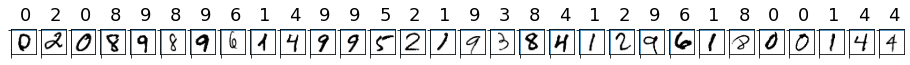

In [ ]:
# make sure utils.py is in the same directory as this code
from utils import load_data
import glob


# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the model converge faster.
X_train = load_data(glob.glob(os.path.join(data_folder,"**/train-images-idx3-ubyte.gz"), recursive=True)[0], False) / 255.0
X_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-images-idx3-ubyte.gz"), recursive=True)[0], False) / 255.0
y_train = load_data(glob.glob(os.path.join(data_folder,"**/train-labels-idx1-ubyte.gz"), recursive=True)[0], True).reshape(-1)
y_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-labels-idx1-ubyte.gz"), recursive=True)[0], True).reshape(-1)


# now let's show some randomly chosen images from the traininng set.
count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

## Train on a remote cluster

For this task, you submit the job to run on the remote training cluster you set up earlier.  To submit a job you:
* Create a directory
* Create a training script
* Create a script run configuration
* Submit the job 

### Create a directory

Create a directory to deliver the necessary code from your computer to the remote resource.

In [ ]:
import os
script_folder = os.path.join(os.getcwd(), "sklearn-mnist")
os.makedirs(script_folder, exist_ok=True)

### Create a training script

To submit the job to the cluster, first create a training script. Run the following code to create the training script called `train.py` in the directory you just created. 

In [ ]:
%%writefile $script_folder/train.py

import argparse
import os
import numpy as np
import glob

from sklearn.linear_model import LogisticRegression
import joblib

from azureml.core import Run
from utils import load_data

# let user feed in 2 parameters, the dataset to mount or download, and the regularization rate of the logistic regression model
parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--regularization', type=float, dest='reg', default=0.01, help='regularization rate')
args = parser.parse_args()

data_folder = args.data_folder
print('Data folder:', data_folder)

# load train and test set into numpy arrays
# note we scale the pixel intensity values to 0-1 (by dividing it with 255.0) so the model can converge faster.
X_train = load_data(glob.glob(os.path.join(data_folder, '**/train-images-idx3-ubyte.gz'), recursive=True)[0], False) / 255.0
X_test = load_data(glob.glob(os.path.join(data_folder, '**/t10k-images-idx3-ubyte.gz'), recursive=True)[0], False) / 255.0
y_train = load_data(glob.glob(os.path.join(data_folder, '**/train-labels-idx1-ubyte.gz'), recursive=True)[0], True).reshape(-1)
y_test = load_data(glob.glob(os.path.join(data_folder, '**/t10k-labels-idx1-ubyte.gz'), recursive=True)[0], True).reshape(-1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep = '\n')

# get hold of the current run
run = Run.get_context()

print('Train a logistic regression model with regularization rate of', args.reg)
clf = LogisticRegression(C=1.0/args.reg, solver="liblinear", multi_class="auto", random_state=42)
clf.fit(X_train, y_train)

print('Predict the test set')
y_hat = clf.predict(X_test)

# calculate accuracy on the prediction
acc = np.average(y_hat == y_test)
print('Accuracy is', acc)

run.log('regularization rate', np.float(args.reg))
run.log('accuracy', np.float(acc))

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=clf, filename='outputs/sklearn_mnist_model.pkl')

Writing /mnt/batch/tasks/shared/LS_root/mounts/clusters/sdg-compute1/code/Users/ts775657/image-classification-mnist-data/sklearn-mnist/train.py


Notice how the script gets data and saves models:

+ The training script reads an argument to find the directory containing the data.  When you submit the job later, you point to the dataset for this argument:
`parser.add_argument('--data-folder', type=str, dest='data_folder', help='data directory mounting point')`


+ The training script saves your model into a directory named outputs. <br/>
`joblib.dump(value=clf, filename='outputs/sklearn_mnist_model.pkl')`<br/>
Anything written in this directory is automatically uploaded into your workspace. You'll access your model from this directory later in the tutorial.

The file `utils.py` is referenced from the training script to load the dataset correctly.  Copy this script into the script folder so that it can be accessed along with the training script on the remote resource.

In [ ]:
import shutil
shutil.copy('utils.py', script_folder)

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/sdg-compute1/code/Users/ts775657/image-classification-mnist-data/sklearn-mnist/utils.py'

### Configure the training job

Create a ScriptRunConfig object to specify the configuration details of your training job, including your training script, environment to use, and the compute target to run on. Configure the ScriptRunConfig by specifying:

* The directory that contains your scripts. All the files in this directory are uploaded into the cluster nodes for execution. 
* The compute target.  In this case you will use the AmlCompute you created
* The training script name, train.py
* An environment that contains the libraries needed to run the script
* Arguments required from the training script. 

In [ ]:
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies

# to install required packages
env = Environment('tutorial-env')
cd = CondaDependencies.create(pip_packages=['azureml-dataset-runtime[pandas,fuse]', 'azureml-defaults'], conda_packages = ['scikit-learn==0.22.1'])

env.python.conda_dependencies = cd

# Register environment to re-use later
env.register(workspace = ws)

{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/intelmpi2018.3-ubuntu16.04:20200821.v1",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "enabled": false,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": null,
    "name": "tutorial-env",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "channels": [
                "anaconda",
                "conda-forge"

Then, create the ScriptRunConfig by specifying the training script, compute target and environment.

In [ ]:
from azureml.core import ScriptRunConfig

args = ['--data-folder', mnist_file_dataset.as_mount(), '--regularization', 0.5]

src = ScriptRunConfig(source_directory=script_folder,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

### Submit the job to the cluster

Run the experiment by submitting the ScriptRunConfig object. And you can navigate to Azure portal to monitor the run.

In [ ]:
run = exp.submit(config=src)
run

Experiment,Id,Type,Status,Details Page,Docs Page
sklearn-mnist,sklearn-mnist_1607344653_06da037e,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


In [ ]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

By the way, if you need to cancel a run, you can follow [these instructions](https://aka.ms/aml-docs-cancel-run).

### Get log results upon completion

Model training happens in the background. You can use `wait_for_completion` to block and wait until the model has completed training before running more code. 

In [ ]:
# specify show_output to True for a verbose log
run.wait_for_completion(show_output=True) 

RunId: sklearn-mnist_1607344653_06da037e
Web View: https://ml.azure.com/experiments/sklearn-mnist/runs/sklearn-mnist_1607344653_06da037e?wsid=/subscriptions/81a2cfd3-9253-4618-933d-5a43c8571c2b/resourcegroups/aidemos/workspaces/try23

Streaming azureml-logs/20_image_build_log.txt

2020/12/07 12:37:50 Downloading source code...
2020/12/07 12:37:51 Finished downloading source code
2020/12/07 12:37:51 Creating Docker network: acb_default_network, driver: 'bridge'
2020/12/07 12:37:52 Successfully set up Docker network: acb_default_network
2020/12/07 12:37:52 Setting up Docker configuration...
2020/12/07 12:37:53 Successfully set up Docker configuration
2020/12/07 12:37:53 Logging in to registry: 855d3db6a8c54b10b11d74a374cec254.azurecr.io
2020/12/07 12:37:54 Successfully logged into 855d3db6a8c54b10b11d74a374cec254.azurecr.io
2020/12/07 12:37:54 Executing step ID: acb_step_0. Timeout(sec): 5400, Working directory: '', Network: 'acb_default_network'
2020/12/07 12:37:54 Scanning for dependen

{'runId': 'sklearn-mnist_1607344653_06da037e',
 'target': 'cpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2020-12-07T12:46:22.071537Z',
 'endTimeUtc': '2020-12-07T12:52:10.943828Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '62231826-3235-4756-a315-54dc1f8cade2',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': '2e77b4b1-b873-4bf6-a0db-bf7bc17951c3'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'input__d9ba7384', 'mechanism': 'Mount'}}],
 'outputDatasets': [],
 'runDefinition': {'script': 'train.py',
  'useAbsolutePath': False,
  'arguments': ['--data-folder',
   'DatasetConsumptionConfig:input__d9ba7384',
   '--regularization',
   '0.5'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'cpu-cluster',
  'dataReferences': {},
  'data': {'input__d9ba7384': {'dataLocation': {

### Display run results

You now have a model trained on a remote cluster.  Retrieve all the metrics logged during the run, including the accuracy of the model:

In [ ]:
print(run.get_metrics())

{'regularization rate': 0.5, 'accuracy': 0.9193}


In the next tutorial you will explore this model in more detail.

## Register model

The last step in the training script wrote the file `outputs/sklearn_mnist_model.pkl` in a directory named `outputs` in the VM of the cluster where the job is executed. `outputs` is a special directory in that all content in this  directory is automatically uploaded to your workspace.  This content appears in the run record in the experiment under your workspace. Hence, the model file is now also available in your workspace.

You can see files associated with that run.

In [ ]:
print(run.get_file_names())

['azureml-logs/20_image_build_log.txt', 'azureml-logs/55_azureml-execution-tvmps_abcc93a4a374fd75d007d67db56a3c414d6cfaa9b87577fe10f342cd69330f82_d.txt', 'azureml-logs/65_job_prep-tvmps_abcc93a4a374fd75d007d67db56a3c414d6cfaa9b87577fe10f342cd69330f82_d.txt', 'azureml-logs/70_driver_log.txt', 'azureml-logs/75_job_post-tvmps_abcc93a4a374fd75d007d67db56a3c414d6cfaa9b87577fe10f342cd69330f82_d.txt', 'azureml-logs/process_info.json', 'azureml-logs/process_status.json', 'logs/azureml/103_azureml.log', 'logs/azureml/dataprep/backgroundProcess.log', 'logs/azureml/dataprep/backgroundProcess_Telemetry.log', 'logs/azureml/dataprep/engine_spans_l_00a54ce9-88ee-4d37-b15f-40742ae80be2.jsonl', 'logs/azureml/dataprep/engine_spans_l_7102e5e8-eaec-48c6-a1c0-fe4787766ee8.jsonl', 'logs/azureml/dataprep/python_span_l_00a54ce9-88ee-4d37-b15f-40742ae80be2.jsonl', 'logs/azureml/dataprep/python_span_l_7102e5e8-eaec-48c6-a1c0-fe4787766ee8.jsonl', 'logs/azureml/job_prep_azureml.log', 'logs/azureml/job_release_azu

Register the model in the workspace so that you (or other collaborators) can later query, examine, and deploy this model.

In [ ]:
# register model 
model = run.register_model(model_name='sklearn_mnist', model_path='outputs/sklearn_mnist_model.pkl')
print(model.name, model.id, model.version, sep='\t')

sklearn_mnist	sklearn_mnist:1	1


#**Ready For Deployment**

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
 
import azureml.core

# Display the core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.18.0


In [ ]:
%%writefile score.py
import json
import numpy as np
import os
import pickle
import joblib

def init():
    global model
    # AZUREML_MODEL_DIR is an environment variable created during deployment.
    # It is the path to the model folder (./azureml-models/$MODEL_NAME/$VERSION)
    # For multiple models, it points to the folder containing all deployed models (./azureml-models)
    model_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'sklearn_mnist_model.pkl')
    model = joblib.load(model_path)

def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    # make prediction
    y_hat = model.predict(data)
    # you can return any data type as long as it is JSON-serializable
    return y_hat.tolist()

Writing score.py


In [ ]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={"data": "MNIST",  "method" : "sklearn"}, 
                                               description='Predict MNIST with sklearn')

In [ ]:
%%time
from azureml.core.webservice import Webservice
from azureml.core.model import InferenceConfig
from azureml.core.environment import Environment
from azureml.core import Workspace
from azureml.core.model import Model

ws = Workspace.from_config()
model = Model(ws, 'sklearn_mnist')


myenv = Environment.get(workspace=ws, name="tutorial-env", version="1")
inference_config = InferenceConfig(entry_script="score.py", environment=myenv)

service = Model.deploy(workspace=ws, 
                       name='sklearn-mnist-svc3', 
                       models=[model], 
                       inference_config=inference_config, 
                       deployment_config=aciconfig)

service.wait_for_deployment(show_output=True)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running...................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
CPU times: user 1.99 s, sys: 156 ms, total: 2.14 s
Wall time: 3min 8s


In [ ]:
print(service.scoring_uri)

http://87a79169-00b0-4d13-854f-94d1bb504771.eastasia.azurecontainer.io/score


In [ ]:
import os
from azureml.core import Dataset
from azureml.opendatasets import MNIST

data_folder = os.path.join(os.getcwd(), 'data')
os.makedirs(data_folder, exist_ok=True)

mnist_file_dataset = MNIST.get_file_dataset()
mnist_file_dataset.download(data_folder, overwrite=True)

['/mnt/batch/tasks/shared/LS_root/mounts/clusters/sdg-compute1/code/Users/ts775657/image-classification-mnist-data/data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/t10k-images-idx3-ubyte.gz',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/sdg-compute1/code/Users/ts775657/image-classification-mnist-data/data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/t10k-labels-idx1-ubyte.gz',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/sdg-compute1/code/Users/ts775657/image-classification-mnist-data/data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/train-images-idx3-ubyte.gz',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/sdg-compute1/code/Users/ts775657/image-classification-mnist-data/data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/train-labels-idx1-ubyte.gz']

In [ ]:
from utils import load_data
import os
import glob

data_folder = os.path.join(os.getcwd(), 'data')
# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster
X_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-images-idx3-ubyte.gz"), recursive=True)[0], False) / 255.0
y_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-labels-idx1-ubyte.gz"), recursive=True)[0], True).reshape(-1)

In [ ]:
import json
test = json.dumps({"data": X_test.tolist()})
test = bytes(test, encoding='utf8')
y_hat = service.run(input_data=test)

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_test, y_hat)
print(conf_mx)
print('Overall accuracy:', np.average(y_hat == y_test))

[[ 960    0    2    2    1    4    6    3    1    1]
 [   0 1113    3    1    0    1    5    1   11    0]
 [   9    8  919   20    9    5   10   12   37    3]
 [   4    0   17  918    2   24    4   11   21    9]
 [   1    4    4    3  913    0   10    3    5   39]
 [  10    2    0   42   11  768   17    7   28    7]
 [   9    3    7    2    6   20  907    1    3    0]
 [   2    9   22    5    8    1    1  948    5   27]
 [  10   15    5   21   15   26    7   11  852   12]
 [   7    8    2   14   32   13    0   26   12  895]]
Overall accuracy: 0.9193


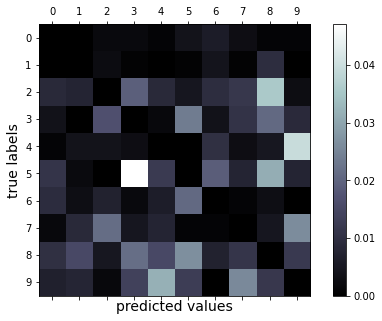

In [ ]:
# normalize the diagonal cells so that they don't overpower the rest of the cells when visualized
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
cax = ax.matshow(norm_conf_mx, cmap=plt.cm.bone)
ticks = np.arange(0, 10, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(ticks)
ax.set_yticklabels(ticks)
fig.colorbar(cax)
plt.ylabel('true labels', fontsize=14)
plt.xlabel('predicted values', fontsize=14)
plt.savefig('conf.png')
plt.show()

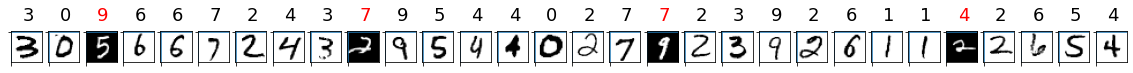

In [ ]:
import json

# find 30 random samples from test set
n = 30
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

test_samples = json.dumps({"data": X_test[sample_indices].tolist()})
test_samples = bytes(test_samples, encoding='utf8')

# predict using the deployed model
result = service.run(input_data=test_samples)

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize = (20, 1))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')
    
    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    
    plt.text(x=10, y=-10, s=result[i], fontsize=18, color=font_color)
    plt.imshow(X_test[s].reshape(28, 28), cmap=clr_map)
    
    i = i + 1
plt.show()

In [ ]:
import requests

# send a random row from the test set to score
random_index = np.random.randint(0, len(X_test)-1)
input_data = "{\"data\": [" + str(list(X_test[random_index])) + "]}"

headers = {'Content-Type': 'application/json'}

# for AKS deployment you'd need to the service key in the header as well
# api_key = service.get_key()
# headers = {'Content-Type':'application/json',  'Authorization':('Bearer '+ api_key)} 

resp = requests.post(service.scoring_uri, input_data, headers=headers)

print("POST to url", service.scoring_uri)
#print("input data:", input_data)
print("label:", y_test[random_index])
print("prediction:", resp.text)

POST to url http://87a79169-00b0-4d13-854f-94d1bb504771.eastasia.azurecontainer.io/score
label: 1
prediction: [1]
